# Question Survey

The first study, called `question-survey`, looked at the effect of social influence on curiousity, using upvotes as proxy for social interest. Below we analyze the responses to test the hypothesis that the same questions, when given higher upvotes, receive higher scores from participants with regards to curiousity.

## Analysis

In [1]:
%load_ext pycodestyle_magic

In [2]:
# Analytical Tools
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# General Utilities
import math
import json
import pprint
import itertools
import importlib

# Custom Utilities
import utilities.processing as processing
import utilities.plotting as plotting
import utilities.describe as describe

# Make printing much more convenient
log = pprint.pprint

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Loading Data

In [3]:
FILE_NAMES = [
    'raw-data/question-setup-question-survey.json',
    'raw-data/question-survey-entries.json'
]

with open(FILE_NAMES[0]) as file:
    literals = json.load(file)

q_text = literals['question_text']
j_text = literals['judgement_text']
QUESTIONS = {ques: 'q' + str(num) for num, ques in enumerate(q_text)}
JUDGEMENTS = {judge: 'j' + str(num) for num, judge in enumerate(j_text)}

In [4]:
with open(FILE_NAMES[1]) as file:
    master_responses = [json.loads(line) for line in file if line]
# Study changed after the first 30 were collected
real_responses = master_responses[30:]
len(real_responses)

100

### Reading Responses into Data
Creates a `DataFrame` based on the survey data.

In [5]:
# Create dictionary to represent future DataFrame
num_questions = len(QUESTIONS)
num_judgements = len(JUDGEMENTS)
col_labels = processing.get_col_labels(num_questions,
                                       num_judgements,
                                       choice=False)
data = {label: [] for label in col_labels}

In [6]:
processing.fill_question_survey_data(data,
                                     real_responses,
                                     QUESTIONS,
                                     JUDGEMENTS)

In [7]:
data = pd.DataFrame(data)
print(data.size)
data.head()

6200


,condition,consent,q0j0,q0j1,q0j2,q0j3,q0j4,q0score,q1j0,q1j1,...,q8j2,q8j3,q8j4,q8score,q9j0,q9j1,q9j2,q9j3,q9j4,q9score
0,A,1,3,3,2,4,4,3381,4,3,...,3,2,2,32,4,3,4,3,3,29
1,A,1,4,4,2,5,2,3362,4,4,...,4,4,2,32,5,0,5,4,2,32
2,A,1,1,4,4,3,4,3365,2,4,...,4,3,3,37,5,2,5,4,4,26
3,A,1,2,1,1,2,1,3370,2,2,...,3,2,3,53,3,2,1,2,2,36
4,A,1,1,0,5,2,5,3370,3,4,...,5,4,0,23,4,2,6,5,0,29


### Analysizing Data

We first split the data into two groups, one corresponding to those which received high scores for group A and one for those who received higher scores for group B. The groups themselves are in the constant section for reference, where the first five entries corresponding to group A and the last five to group B.

In [8]:
# Remove participants without consent
data = data[data.consent == 1]
print(data.size, len(data))
# Creates useful lists
sorted_question_labels = sorted(QUESTIONS.values())
judgements_labels = sorted(JUDGEMENTS.values())
group_a_question_labels = sorted_question_labels[:5]
group_b_question_labels = sorted_question_labels[5:]

6200 100


In [9]:
# Insert group a and b averages for each person
for j_num in judgements_labels:
    group_a_columns = [q_num + j_num for q_num in group_a_question_labels]
    group_b_columns = [q_num + j_num for q_num in group_b_question_labels]
    group_a_averages = data[group_a_columns].mean(axis=1)
    group_b_averages = data[group_b_columns].mean(axis=1)
    data['{}_a_avg'.format(j_num)] = group_a_averages
    data['{}_b_avg'.format(j_num)] = group_b_averages
data.head()

,condition,consent,q0j0,q0j1,q0j2,q0j3,q0j4,q0score,q1j0,q1j1,...,j0_a_avg,j0_b_avg,j1_a_avg,j1_b_avg,j2_a_avg,j2_b_avg,j3_a_avg,j3_b_avg,j4_a_avg,j4_b_avg
0,A,1,3,3,2,4,4,3381,4,3,...,3.2,3.2,2.8,3.2,2.2,2.8,3.2,3.2,2.8,2.6
1,A,1,4,4,2,5,2,3362,4,4,...,2.4,2.2,2.0,0.8,2.0,3.6,4.8,4.0,1.8,1.0
2,A,1,1,4,4,3,4,3365,2,4,...,2.6,3.6,2.6,1.6,4.2,4.2,3.4,4.2,3.2,3.0
3,A,1,2,1,1,2,1,3370,2,2,...,1.4,2.4,1.0,2.0,1.8,2.0,2.2,2.2,1.6,2.0
4,A,1,1,0,5,2,5,3370,3,4,...,1.6,2.0,1.0,1.4,4.6,4.0,3.8,4.6,5.0,0.0


In [10]:
# Seperate into dataframes for each condition!
high_a = data[data.condition == 'A']
high_b = data[data.condition == 'B']
a_size, b_size = len(high_a), len(high_b)
a_size, b_size

(54, 46)

### Intial Analysis
To get a feel for the raw data, we look at the average rating over the five questions in each group, for each judgement. We now have four groups: (1) group a questions with high scores, (2) group b questions with low scores, (3) group b questions with high scores, and (4) group a questions with low scores. Notice each participants either contributes data for groups (1) and (2) or (3) and (4) depending on which condition they were placed in.

Below we roughly compare the group a questions with high vs low scores and group b question with high vs low score. This introduces variance between participants absolute rating scales as a confound, since a different group of people rate the question with high scores versus with low scores.

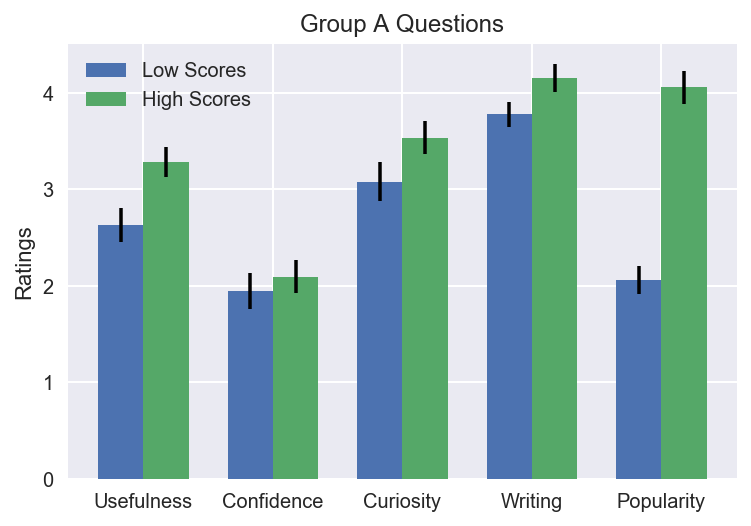

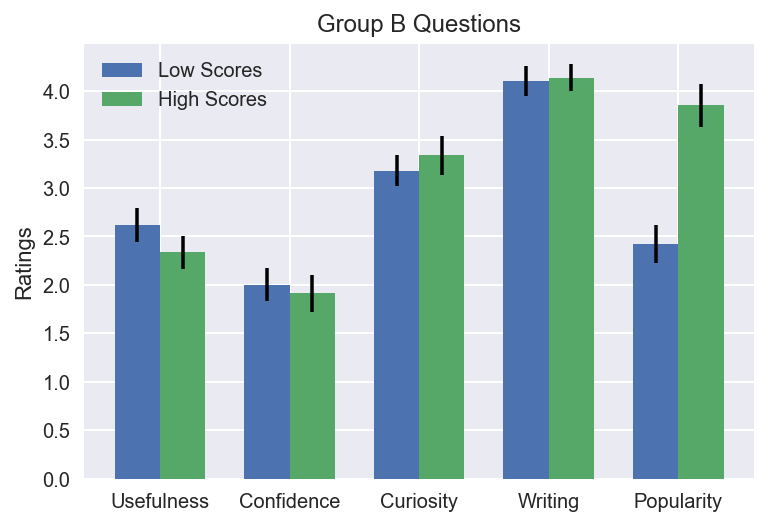

In [11]:
# Group A Rawe Plots
PLOTTING_OPTIONS = {
    'y_label': 'Ratings',
    'ticks': ['Usefulness', 'Confidence', 'Curiosity',
              'Writing', 'Popularity'],
    'legend': ['Low Scores', 'High Scores'],
    'title': 'Group A Questions'
}

high_avg, high_err = [], []
low_avg, low_err = [], []
for j_num in judgements_labels:
    all_high_points = high_a['{}_a_avg'.format(j_num)]
    all_low_points = high_b['{}_a_avg'.format(j_num)]
    high_avg.append(all_high_points.mean())
    high_err.append(all_high_points.std() / math.sqrt(a_size))
    low_avg.append(all_low_points.mean())
    low_err.append(all_low_points.std() / math.sqrt(b_size))

plotting.plot_double_bar(low_avg, low_err, high_avg, high_err,
                         **PLOTTING_OPTIONS)

# Group B Raw Plots
PLOTTING_OPTIONS = {
    'y_label': 'Ratings',
    'ticks': ['Usefulness', 'Confidence', 'Curiosity',
              'Writing', 'Popularity'],
    'legend': ['Low Scores', 'High Scores'],
    'title': 'Group B Questions'
}

high_avg, high_err = [], []
low_avg, low_err = [], []
for j_num in judgements_labels:
    all_high_points = high_b['{}_b_avg'.format(j_num)]
    all_low_points = high_a['{}_b_avg'.format(j_num)]
    high_avg.append(all_high_points.mean())
    high_err.append(all_high_points.std() / math.sqrt(b_size))
    low_avg.append(all_low_points.mean())
    low_err.append(all_low_points.std() / math.sqrt(a_size))

plotting.plot_double_bar(low_avg, low_err, high_avg, high_err,
                         **PLOTTING_OPTIONS)

### Paired Samples Test
To remove this confound, we switch to a paired samples t-test, comparing the difference in ratings each person gave to higher rated questions versus lower rated question. Since each particpant is randomly assigned to the high a condition versus the high b condition, any bias from which question were given higher scores should wash out.

Usefulness: t = -2.06, p = 0.042 (1 greater)
Confidence: t = -0.442, p = 0.659 (1 greater)
Curiosity: t = -3.25, p = 0.00159 (1 greater)
Writing: t = -2.7, p = 0.00813 (1 greater)
Popularity: t = -9.25, p = 4.63e-15 (1 greater)


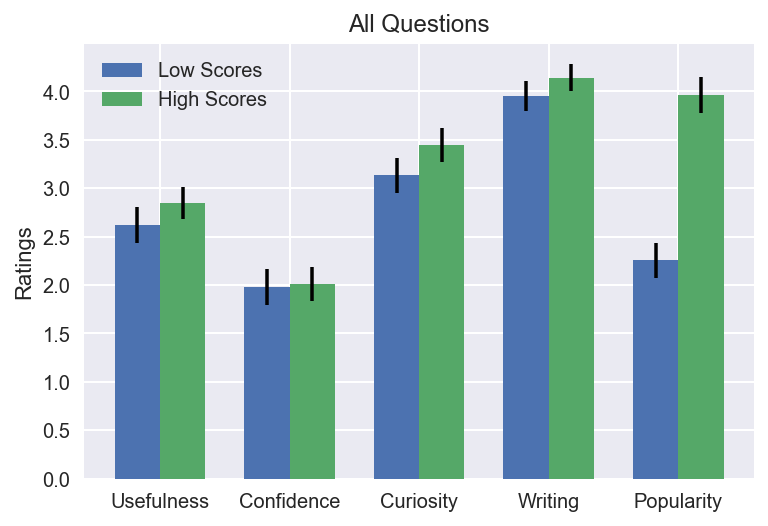

In [12]:
PLOTTING_OPTIONS = {
    'y_label': 'Ratings',
    'ticks': ['Usefulness', 'Confidence', 'Curiosity',
              'Writing', 'Popularity'],
    'legend': ['Low Scores', 'High Scores'],
    'title': 'All Questions'
}

high_avg, high_err = [], []
low_avg, low_err = [], []
for index, j_num in enumerate(judgements_labels):
    all_high_points = np.concatenate((high_a['{}_a_avg'.format(j_num)],
                                      high_b['{}_b_avg'.format(j_num)]))
    all_low_points = np.concatenate((high_a['{}_b_avg'.format(j_num)],
                                     high_b['{}_a_avg'.format(j_num)]))
    high_avg.append(all_high_points.mean())
    high_err.append(all_high_points.std() / math.sqrt(a_size))
    low_avg.append(all_low_points.mean())
    low_err.append(all_low_points.std() / math.sqrt(b_size))

    print(describe.paired_t_test(all_low_points,
                                 all_high_points,
                                 PLOTTING_OPTIONS['ticks'][index]))

plotting.plot_double_bar(low_avg, low_err, high_avg, high_err,
                         **PLOTTING_OPTIONS)